## Case Study: Smart TVs

### Import libraries

In [5]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract
import random
import math

In [2]:
tv_ssl = pd.read_parquet("../datasets/smarttv_ssl.parquet")

In [3]:
tv_ssl.shape

(1093117, 21)

In [4]:
tv_ssl.sample(1)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,folder_name,capture_name
688792,1557673894.467775,CUvsfZ3W1ms512fsYk,10.42.0.20,45659.0,104.88.11.103,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,secp256r1,niagara.cc.com,F,-,http/1.1,T,CsxknGIti,"12e0525fdca6a471cf1bdb048016974f3db9e1e73592874ac5dd91aa6e6fa0a4,154c433c491929c5ef686e838e323664a00e6a0d822ccc958fb4dab03e49a08f",(empty),T,ok,amazon-data-20190510-205355,com.mtvn.vh1android-1557673593


### Dataframe process

In [6]:
tv_ssl = tv_ssl.loc[tv_ssl['cert_chain_fps'].notna()]
tv_ssl['fingerprint'] = tv_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[0])
tv_ssl['vendor'] = tv_ssl['folder_name'].apply(lambda x: x.split("-")[0])

In [7]:
tv_x509 = pd.read_parquet("../datasets/smarttv_x509.parquet")

In [8]:
tv_x509.shape

(222434, 24)

In [9]:
tv_x509.sample(1)

,ts,fingerprint,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,folder_name,capture_name
219189,1556747312.035975,54fa41cf45cb52cb2b930d2c3e86278a6d558ab23f0e6af1b7c7bfbeb2022be4,3.0,0E2895B49438,CN=*.bidswitch.net,"O=mitmproxy,CN=mitmproxy",1.556589e+09,1.619834e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537,-,"*.bidswitch.net,x.bidswitch.net,bidswitch.net",-,-,35.185.64.230,-,-,T,F,roku-data-20190501-125316,90598-1556747217


In [10]:
tv_x509 = tv_x509.loc[tv_x509['certificate.version'].notna()]

In [11]:
tv_x509.shape

(211424, 24)

In [12]:
tv_x509['certificate.issuer'] = tv_x509['certificate.issuer'].fillna("missing")
tv_x509['certificate.subject'] = tv_x509['certificate.subject'].fillna("missing")

tv_x509['issuer_O'] = tv_x509['certificate.issuer'].apply(lambda x: x.split("O=")[-1].split(",")[0])
tv_x509['issuer_CN'] = tv_x509['certificate.issuer'].apply(lambda x: x.split("CN=")[-1].split(",")[0])
tv_x509['subject_CN'] = tv_x509['certificate.subject'].apply(lambda x: x.split("CN=")[-1].split(",")[0])

tv_x509['certificate.not_valid_before'] = tv_x509['certificate.not_valid_before'].fillna(0)
tv_x509['certificate.not_valid_after'] = tv_x509['certificate.not_valid_after'].fillna(0)
tv_x509['not_before'] = tv_x509['certificate.not_valid_before'].apply(lambda x: \
                                         datetime.datetime.fromtimestamp(x).strftime("%m/%d/%Y, %H:%M:%S"))
tv_x509['not_after'] = tv_x509['certificate.not_valid_after'].apply(lambda x: \
                                         datetime.datetime.fromtimestamp(x).strftime("%m/%d/%Y, %H:%M:%S"))
tv_x509['validity_days'] = tv_x509.apply(lambda x: \
                                         (datetime.datetime.fromtimestamp(x['certificate.not_valid_after']) - \
                                          datetime.datetime.fromtimestamp(x['certificate.not_valid_before'])).days, \
                                          axis=1)
tv_x509['date'] = tv_x509['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)))

### Servers visited; certificates received

In [13]:
tv_ssl_dropdup = tv_ssl.drop_duplicates(['server_name', 'validation_status', 'cert_chain_fps', 'version', 'vendor'])

In [14]:
tv_x509_dropdup = tv_x509.drop_duplicates(['fingerprint', 'certificate.issuer', 'validity_days'])

In [15]:
tv_dropdup_merge = pd.merge(tv_ssl_dropdup, tv_x509_dropdup, left_on='fingerprint', right_on='fingerprint', how='left')

In [16]:
tv_dropdup_merge.loc[tv_dropdup_merge.vendor == "amazon_manual_v2", "vendor"] = "amazon"

In [17]:
tv_dropdup_filter = tv_dropdup_merge.loc[(tv_dropdup_merge['vendor'] == "amazon") | \
                                         (tv_dropdup_merge['vendor'] == "roku")]

In [18]:
tv_dropdup_filter = tv_dropdup_filter.drop_duplicates(['server_name','validation_status', 'cert_chain_fps', 'version', 'vendor', \
                                                       'fingerprint', 'certificate.issuer', 'validity_days'])

In [19]:
tv_dropdup_filter.shape

(66473, 53)

In [20]:
tv_dropdup_filter['vendor'].value_counts()

amazon    43130
roku      23343
Name: vendor, dtype: int64

In [21]:
tv_dropdup_filter['domain'] = tv_dropdup_filter['server_name'].apply(lambda x: "{}.{}".format(tldextract.extract(x).domain, \
                                                                                              tldextract.extract(x).suffix))

In [22]:
amazon = tv_dropdup_filter.loc[(tv_dropdup_filter['vendor'] == "amazon") & \
                               (tv_dropdup_filter['issuer_O'] != "mitmproxy")]

In [23]:
amazon.shape

(3574, 54)

In [24]:
roku = tv_dropdup_filter.loc[(tv_dropdup_filter['vendor'] == "roku") & \
                             (tv_dropdup_filter['issuer_O'] != "mitmproxy") & \
                             (tv_dropdup_filter['issuer_CN'] != "3016sale.xyz")]

In [25]:
roku.shape

(5618, 54)

In [26]:
amazon_domain_lis = list(set(amazon['domain'].tolist()))
roku_domain_lis = list(set(roku['domain'].tolist()))

In [27]:
comm_lis = list(set(amazon_domain_lis).intersection(roku_domain_lis))

In [28]:
len(comm_lis)

448

In [29]:
amazon_only = amazon.loc[~amazon['domain'].isin(comm_lis)]

In [30]:
roku_only = roku.loc[~roku['domain'].isin(comm_lis)]

In [31]:
amazon_filter = amazon_only.loc[(amazon_only['domain'].str.startswith("amazon")) | \
                                ((amazon_only['domain'].str.startswith("aws")))]

In [32]:
roku_filter = roku_only.loc[roku_only['domain'].str.startswith("roku")]

In [33]:
amazon_filter.shape

(15, 54)

In [34]:
amazon_filter[['server_name', 'issuer_O', 'issuer_CN', 'certificate.serial', 'validation_status', 'validity_days']]

,server_name,issuer_O,issuer_CN,certificate.serial,validation_status,validity_days
0,wl.amazon-dss.com,Amazon,Amazon,08A26BEFA71D81D79508693990771B5A,ok,396.0
84,api.amazonalexa.com,Amazon,Amazon,0FB4B5976D52A9921F101098DE2E7A92,ok,359.0
97,resources.amazonwebapps.com,Amazon,Amazon,09A766AD4B80FAFB273974941A52DA85,ok,356.0
160,api.amazonalexa.com,NaN,NaN,NaN,-,NaN
372,amazonchannelstudio-cdn.com,Amazon,Amazon,08EAA6793D35E0A26DE3496AEC464D16,ok,396.0
374,amazonchannelstudio-cdn.com,NaN,NaN,NaN,-,NaN
4788,wl.amazon-dss.com,NaN,NaN,NaN,-,NaN
6024,wl.amazon-dss.com,NaN,NaN,NaN,-,NaN
19063,global.safebrowsing.service.amazonsilk.com,Amazon,Amazon,091679203A511E77451BEF79F40F17AE,ok,365.0
25935,wl.amazon-dss.com,NaN,NaN,NaN,-,NaN


In [35]:
roku_filter.shape

(8, 54)

In [36]:
roku_filter

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,folder_name_x,capture_name_x,fingerprint,vendor,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,folder_name_y,capture_name_y,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,date,domain
1685,1563327043.351951,CclahU26NTou6pc3b,10.42.0.119,41126.0,34.197.164.98,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,api.rokutime.com,F,unknown_ca,-,F,CsxknL,"34ae4ff5721ef09116308e2064579079d94a75160052efc7cde8b4d8da5630d6,25847d668eb4f04fdd40b12b6b0740c567da7d024308eb6c2c96fe41d9de218d",(empty),F,ok,roku-data-20190716-121233,48631-1563326967,34ae4ff5721ef09116308e2064579079d94a75160052efc7cde8b4d8da5630d6,roku,1563308100.038230,3.0,0392B46869F744E54501EBDDBC9DDC03881D,CN=3016sale.xyz,"CN=Let's Encrypt Authority X3,O=Let's Encrypt,C=US",1.562895e+09,1.570671e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537,-,3016sale.xyz,-,-,-,F,-,T,F,roku-data-20190716-121233,215768-1563308069,Let's Encrypt,Let's Encrypt Authority X3,3016sale.xyz,"07/11/2019, 21:33:16","10/09/2019, 21:33:16",90.0,2019-07-16 16:15:00.038230,rokutime.com
1686,1563327043.367308,CpAMr82LQxxViCTcml,10.42.0.119,41127.0,34.197.164.98,443.0,-,-,-,api.rokutime.com,F,handshake_failure,-,F,Cl,-,-,-,-,roku-data-20190716-121233,48631-1563326967,-,roku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,rokutime.com
8382,1552589994.342402,C23bpfS67siBKrORh,10.42.0.119,38927.0,34.197.164.98,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,api.rokutime.com,F,-,-,T,CsxknGIi,"8b5a7181cb5a51e5326016f3528119211da9c865c6a133dc74086a25133820f2,130d0d65193ffcaa524951b5220e5187f8cb310efff71cf383ed4687050702e3",(empty),T,self signed certificate in certificate chain,roku-data-20190314-161246,32614-1552589788,8b5a7181cb5a51e5326016f3528119211da9c865c6a133dc74086a25133820f2,roku,1552589994.361401,3.0,200C,"CN=api.rokutime.com,OU=PlayerServices,O=Roku\\, Inc.,L=Los Gatos,ST=California,C=US","OU=Roku Server Certification Authority,O=Roku\\, Inc.,L=Saratoga,ST=California,C=US",1.220285e+09,1.583804e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537,-,"api.rokutime.com,ntp.rokutime.com",-,-,-,F,-,T,F,roku-data-20190314-161246,32614-1552589788,Roku\\,OU=Roku Server Certification Authority,api.rokutime.com,"09/01/2008, 12:00:00","03/09/2020, 21:39:55",4207.0,2019-03-14 14:59:54.361401,rokutime.com
13507,1557383964.657148,CsC7l68amrIjiwOTb,10.42.0.119,41844.0,162.241.224.14,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,secp256r1,www.roku-photoview.com,F,-,http/1.1,T,CsxknGIi,"a1c723cc195852e55442f377e7189dbb81bd11972b6b2aa52aed5fa0c0f910d6,25847d668eb4f04fdd40b12b6b0740c567da7d024308eb6c2c96fe41d9de218d",(empty),T,ok,roku-data-20190508-013650,133629-1557383933,a1c723cc195852e55442f377e7189dbb81bd11972b6b2aa52aed5fa0c0f910d6,roku,1557383964.690789,3.0,04EF7490723CB127EC70DDDD9D89A6E4ADD6,CN=roku-photoview.com,"CN=Let's Encrypt Authority X3,O=Let's Encrypt,C=US",1.553418e+09,1.561194e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537,-,"autodiscover.roku-photoview.com,cpanel.roku-photoview.com,mail.roku-photoview.com,roku-photoview.com,webdisk.roku-photoview.com,webmail.roku-photoview.com,www.roku-photoview.com",-,-,-,F,-,T,F,roku-data-20190508-013650,133629-1557383933,Let's Encrypt,Let's Encrypt Authority X3,roku-photoview.com,"03/24/2019, 04:53:37","06/22/2019, 04:53:37",90.0,2019-05-09 02:39:24.690789,roku-photoview.com
13508,1557384074.234420,CA

In [37]:
amazon_vendor = amazon.loc[(amazon['domain'].str.startswith("amazon")) | \
                          ((amazon['domain'].str.startswith("aws")))]

In [38]:
roku_vendor = roku.loc[roku['domain'].str.startswith("roku")]

In [39]:
amazon_vendor = amazon_vendor.loc[amazon_vendor['certificate.issuer'].notna()]

In [40]:
roku_vendor = roku_vendor.loc[(roku_vendor['certificate.issuer'].notna()) &\
                              (roku_vendor['subject_CN'] != "3016sale.xyz")]

In [41]:
amazon_vendor['vendor'] = "Amazon"

In [42]:
amazon_vendor['issuer_O'] = amazon_vendor['issuer_O'].apply(lambda x: x.split(" Inc")[0])

In [43]:
amazon_vendor['issuer_O'].value_counts()

Amazon      65
DigiCert    61
Name: issuer_O, dtype: int64

In [44]:
amazon_vendor_temp = amazon_vendor.loc[~amazon_vendor['server_name'].str.endswith("s3.amazonaws.com")]
amazon_vendor_temp = amazon_vendor_temp.loc[~amazon_vendor_temp['server_name'].str.endswith("amazonaws.com")]
amazon_vendor2 = amazon_vendor_temp.loc[~amazon_vendor_temp['server_name'].str.endswith("amazonvideo.com")]

In [105]:
amazon_vendor2['server_name'].value_counts()

www.amazon.com                                4
atv-ext.amazon.com                            3
mas-sdk.amazon.com                            3
arcus-uswest.amazon.com                       3
na.account.amazon.com                         2
mas-ext.amazon.com                            2
dp-rsm-prod.amazon.com                        2
device-metrics-us.amazon.com                  2
fls-na.amazon.com                             2
api.amazonalexa.com                           2
ktpx.amazon.com                               2
wl.amazon-dss.com                             2
api.amazon.com                                2
music.amazon.com                              2
prime.amazon.com                              2
aviary.amazon.com                             2
aca-livecards-service.amazon.com              1
ags-ext.amazon.com                            1
aax-us.amazon-adsystem.com                    1
unagi-na.amazon.com                           1
aax.amazon-adsystem.com                 

### Note: manual checked against crt.sh

In [45]:
amazon_vendor2['In CT'] = True

<ipython-input-45-f4fa36be3efa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_vendor2['In CT'] = True


In [46]:
roku_vendor['vendor'] = "Roku"

In [47]:
roku_vendor['issuer_O'] = roku_vendor['issuer_O'].apply(lambda x: x.split(" Inc")[0])
roku_vendor.loc[roku_vendor.issuer_O == "Roku\\\\", "issuer_O"] = "Roku"

In [48]:
roku_vendor['issuer_O'].value_counts()

Amazon           27
Roku             19
DigiCert          4
Let's Encrypt     2
Name: issuer_O, dtype: int64

In [49]:
roku_vendor['In CT'] = True
roku_vendor.loc[roku_vendor.issuer_O == "Roku", "In CT"] = False

### Plot by groups

In [50]:
tv_fig = amazon_vendor2[['server_name', 'vendor', 'issuer_O', 'In CT', 'validity_days']]
roku_fig = roku_vendor[['server_name', 'vendor', 'issuer_O', 'In CT', 'validity_days']]

In [51]:
tv_fig = tv_fig.append(roku_fig, ignore_index=True)

In [52]:
tv_fig['cert_day_log10'] = tv_fig['validity_days'].apply(lambda x: np.log10(x))

In [53]:
def jitter(x):
    return x + random.uniform(0, .65) - .3

In [54]:
vendor_ids = {'Amazon': 1, 'Roku': 2}

tv_fig['vendor_id'] = tv_fig['vendor'].apply(lambda x: vendor_ids[x])
tv_fig['jittered'] = tv_fig['vendor_id'].apply(lambda x: jitter(x))

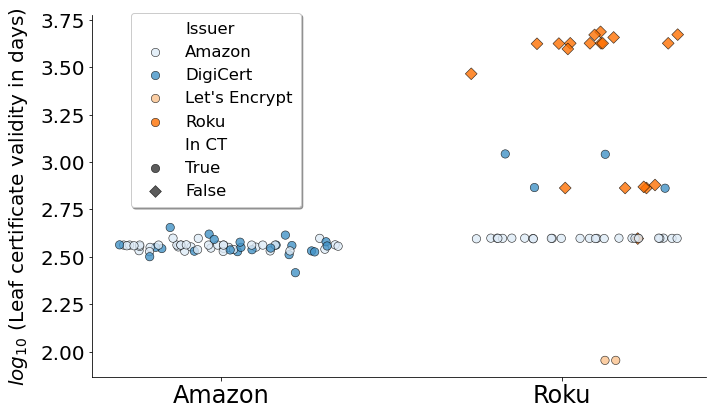

In [55]:
fig = plt.figure(figsize=(10,5.8))
#sns.despine(bottom=True, left=True)

# order: Amazon, DigiCert, Roku, Let's Encrypt
issuer_palette = ["#deebf7", "#4292c6", "#FE7102", "#FBC28D"]
markers = {True: "o", False: "D"}

ax = sns.scatterplot(x="jittered", y="cert_day_log10", style="In CT", hue="issuer_O", s=70, \
                     palette=issuer_palette, markers=markers, \
                     data=tv_fig, alpha=0.8, linewidth=.6, edgecolor='black', x_jitter=True)

ax.set_xlabel('')
ax.set_ylabel("$log_{10}$ (Leaf certificate validity in days)", fontsize=20, labelpad=10)
plt.yticks(fontsize=20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=[handles[0], handles[1], handles[2], handles[4], handles[3], handles[5], handles[7], handles[6]], \
                   labels=["Issuer", labels[1], labels[2], labels[4], labels[3], labels[5], labels[7], labels[6]], \
                   title="", loc="upper left", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=1,\
                   fontsize=16.5, bbox_to_anchor=[0.05, 1.03])
legend.get_frame().set_alpha(None)
for handle in legend.legendHandles:
    handle.set_sizes([70.0])
    handle.set_alpha(0.8)
    handle.set_edgecolor('black')
    handle.set_linewidth(0.6)

plt.xticks([1,2], fontsize=18)
ax.set_xticklabels(['Amazon', 'Roku'], fontsize=24)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.tight_layout()
plt.show()

### Analysis on invalid chain

In [56]:
amazon['validation_status'].value_counts().nlargest(5)

ok                                        2572
-                                          984
unable to get local issuer certificate       9
self signed certificate                      3
certificate has expired                      3
Name: validation_status, dtype: int64

In [57]:
amazon.loc[amazon['validation_status'] == "unable to get local issuer certificate"]['issuer_O'].value_counts()

Symantec Corporation    5
COMODO CA Limited       2
GoDaddy.com\\           1
GeoTrust Inc.           1
Name: issuer_O, dtype: int64

In [58]:
amazon.loc[amazon['validation_status'] == "self signed certificate in certificate chain"]['domain'].value_counts()

roku.com    2
-.          1
Name: domain, dtype: int64

In [59]:
amazon.loc[amazon['validation_status'] == "certificate has expired"]['issuer_O'].value_counts()

GoDaddy.com\\       1
Amazon              1
GlobalSign nv-sa    1
Name: issuer_O, dtype: int64

In [60]:
amazon.loc[amazon['validation_status'] == "certificate has expired"]['server_name'].value_counts()

arcus-uswest.amazon.com    1
www.clikia.com             1
-                          1
Name: server_name, dtype: int64

In [61]:
roku['validation_status'].value_counts().nlargest(5)

ok                                              3937
-                                               1632
unable to get local issuer certificate            29
self signed certificate in certificate chain      14
certificate has expired                            5
Name: validation_status, dtype: int64

In [62]:
roku.loc[roku['validation_status'] == "unable to get local issuer certificate"]['issuer_O'].value_counts()

Netflix\\               7
Roku\\                  6
Symantec Corporation    5
DigiCert Inc            3
VUDU\\                  3
COMODO CA Limited       3
GoDaddy.com\\           1
Let's Encrypt           1
Name: issuer_O, dtype: int64

In [63]:
roku.loc[roku['validation_status'] == "self signed certificate in certificate chain"]['domain'].value_counts()

roku.com        12
netflix.com      1
rokutime.com     1
Name: domain, dtype: int64

In [64]:
roku.loc[roku['validation_status'] == "certificate has expired"]['issuer_O'].value_counts()

GoDaddy.com\\        3
DigiCert Inc         1
COMODO CA Limited    1
Name: issuer_O, dtype: int64